## Predicción de duración de viajes y detección de emergencias en tweets
### Borja Lacalle & Manuel Arias

In [88]:
# Importamos librerías #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PowerTransformer


Parte 1: Predicción de duración de viajes

In [89]:
df = pd.read_csv("uber_time_labels.csv")
df

,id,duration
0,0,455.0
1,1,413.0
2,2,1501.0
3,3,514.0
4,4,605.0
...,...,...
399995,399995,1957.0
399996,399996,167.0
399997,399997,1200.0
399998,399998,1654.0


In [90]:
dfex = pd.read_csv("uber_time_examples.csv")
dfex

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10
0,0,01-07 17:04:08,2,1.20,263,141,12.513054,297.430685,56.317405,405.20,0.408689,126.689773
1,1,03-02 17:41:40,1,0.88,246,68,6.256527,278.205127,27.160167,314.88,-0.256911,126.693467
2,2,02-17 12:15:00,3,7.61,24,13,18.769581,27.141964,5.192385,44.61,56.880789,126.615789
3,3,03-30 13:59:42,1,1.50,239,163,6.256527,270.288721,65.104518,403.50,1.218689,126.686311
4,4,02-14 18:26:55,1,1.20,142,229,6.256527,160.589952,91.465857,372.20,0.408689,126.689773
...,...,...,...,...,...,...,...,...,...,...,...,...
399995,399995,01-31 22:02:08,1,10.00,234,244,6.256527,264.634146,97.457070,488.00,98.968689,126.588204
399996,399996,01-17 15:38:24,1,0.40,162,229,6.256527,183.208255,91.465857,391.40,-0.871311,126.699007
399997,399997,03-13 07:06:05,1,6.18,262,244,6.256527,296.299770,97.457070,512.18,37.161089,126.632294
399998,399998,01-25 17:45:06,2,8.09,138,233,12.513054,156.066291,93.063513,379.09,64.416789,126.610249


In [91]:
data = pd.merge(df, dfex, on='id', how='inner')
data = data.set_index('id')
data 

,duration,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10
id,,,,,,,,,,,,
0,455.0,01-07 17:04:08,2,1.20,263,141,12.513054,297.430685,56.317405,405.20,0.408689,126.689773
1,413.0,03-02 17:41:40,1,0.88,246,68,6.256527,278.205127,27.160167,314.88,-0.256911,126.693467
2,1501.0,02-17 12:15:00,3,7.61,24,13,18.769581,27.141964,5.192385,44.61,56.880789,126.615789
3,514.0,03-30 13:59:42,1,1.50,239,163,6.256527,270.288721,65.104518,403.50,1.218689,126.686311
4,605.0,02-14 18:26:55,1,1.20,142,229,6.256527,160.589952,91.465857,372.20,0.408689,126.689773
...,...,...,...,...,...,...,...,...,...,...,...,...
399995,1957.0,01-31 22:02:08,1,10.00,234,244,6.256527,264.634146,97.457070,488.00,98.968689,126.588204
399996,167.0,01-17 15:38:24,1,0.40,162,229,6.256527,183.208255,91.465857,391.40,-0.871311,126.699007
399997,1200.0,03-13 07:06:05,1,6.18,262,244,6.256527,296.299770,97.457070,512.18,37.161089,126.632294


In [92]:
# Convertir la columna 'fecha' al tipo de dato datetime
data['feature_0'] = pd.to_datetime(data['feature_0'], format='%m-%d %H:%M:%S')

# Cambiar el tipo de dato de la columna 'fecha' a datetime64
data['feature_0'] = data['feature_0'].astype('datetime64')

In [93]:

data.dtypes

duration             float64
feature_0     datetime64[ns]
feature_1              int64
feature_2            float64
feature_3              int64
feature_4              int64
feature_5            float64
feature_6            float64
feature_7            float64
feature_8            float64
feature_9            float64
feature_10           float64
dtype: object

In [94]:
# Contar el número total de valores en cada columna
total_values = data.shape[0]

# Calcular el número de valores missing en cada columna
num_missing = data.isnull().sum()

# Calcular el porcentaje de valores missing en cada columna
percent_missing = num_missing / total_values * 100
percent_missing

duration      0.0
feature_0     0.0
feature_1     0.0
feature_2     0.0
feature_3     0.0
feature_4     0.0
feature_5     0.0
feature_6     0.0
feature_7     0.0
feature_8     0.0
feature_9     0.0
feature_10    0.0
dtype: float64

Vemos que no hay ningún valor missing por lo tanto seguimos con nuestro análisis sin necesidad de rellenarlos con la media, la moda o valores muy distintos

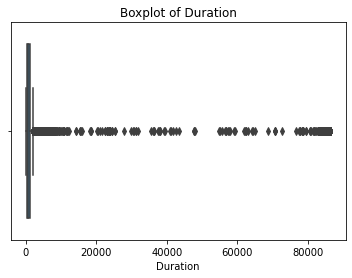

In [95]:
sns.boxplot(data=data, x='duration')
plt.xlabel('Duration')
plt.title('Boxplot of Duration')
plt.show()

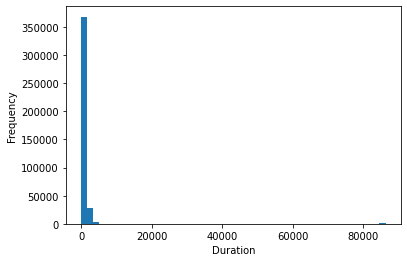

In [96]:

plt.hist(data['duration'], bins=50)
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.show()

Con estos dos gráficos podemos observar que la variable objetivo 'duration' no sigue una distribución normal (es estrecha, asimétrica y cercana a 0) y por lo tanto tendremos que hacer una transformación 

In [97]:
# Obtener la variable "duration" del DataFrame
duration = data['duration'].values.reshape(-1, 1)

# Aplicar Power Transformation
pt = PowerTransformer(method='yeo-johnson')
duration_transformed = pt.fit_transform(duration)

# Reemplazar la columna "duration" con la versión transformada
data['duration_transformed'] = duration_transformed
data.head(10)

,duration,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,duration_transformed
id,,,,,,,,,,,,,
0,455.0,1900-01-07 17:04:08,2,1.20,263,141,12.513054,297.430685,56.317405,405.20,0.408689,126.689773,-0.378044
1,413.0,1900-03-02 17:41:40,1,0.88,246,68,6.256527,278.205127,27.160167,314.88,-0.256911,126.693467,-0.490657
2,1501.0,1900-02-17 12:15:00,3,7.61,24,13,18.769581,27.141964,5.192385,44.61,56.880789,126.615789,1.083267
3,514.0,1900-03-30 13:59:42,1,1.50,239,163,6.256527,270.288721,65.104518,403.50,1.218689,126.686311,-0.235028
4,605.0,1900-02-14 18:26:55,1,1.20,142,229,6.256527,160.589952,91.465857,372.20,0.408689,126.689773,-0.041645
5,297.0,1900-01-19 16:02:13,1,0.80,142,239,6.256527,160.589952,95.459999,381.80,-0.391311,126.694390,-0.867537
6,271.0,1900-03-17 11:37:31,1,1.80,141,233,6.256527,159.459036,93.063513,375.80,2.208689,126.682848,-0.970486
7,3041.0,1900-02-03 18:43:19,2,1.60,24,42,12.513054,27.141964,16.775397,67.60,1.528689,126.685156,2.014532
8,471.0,1900-03-13 11:19:49,1,1.00,239,238,6.256527,270.288721,95.060585,478.00,-0.031311,126.692082,-0.337646


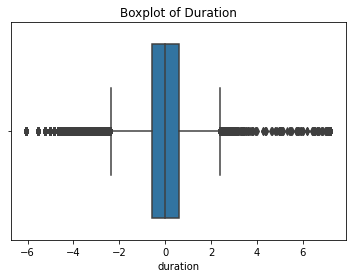

In [98]:
sns.boxplot(data=data, x='duration_transformed')
plt.xlabel('duration')
plt.title('Boxplot of Duration')
plt.show()

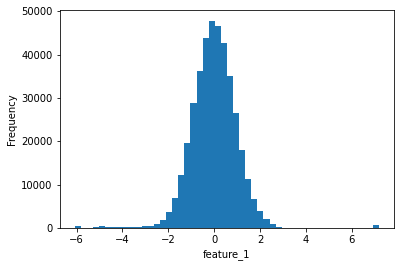

In [99]:
plt.hist(data['duration_transformed'], bins=50)
plt.xlabel('feature_1')
plt.ylabel('Frequency')
plt.show()

Hemos aplicado un PowerTransformer a la variable objetivo 'duration' y como podemos ver en el boxplot e histograma ahora la variable sigue una distribucion normal y es simétrica, condiciones necesarias para la aplicación posterior de los modelos predictivos